# Análise de Classificação kNN - Dataset HTRU2

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import seaborn as sns

## Carregamento dos Dados

In [2]:
colunas = [
    'mean_integrated_profile',
    'std_integrated_profile',
    'kurtosis_integrated_profile',
    'skewness_integrated_profile',
    'mean_dmsnr_curve',
    'std_dmsnr_curve',
    'kurtosis_dmsnr_curve',
    'skewness_dmsnr_curve',
    'class'
]

df = pd.read_csv('htru_2.csv', names=colunas)
print(f"Dimensões do dataset: {df.shape}")
print(f"Features: {df.shape[1]-1}")
print(f"Amostras: {df.shape[0]}")
df.head()

Dimensões do dataset: (17898, 9)
Features: 8
Amostras: 17898


,mean_integrated_profile,std_integrated_profile,kurtosis_integrated_profile,skewness_integrated_profile,mean_dmsnr_curve,std_dmsnr_curve,kurtosis_dmsnr_curve,skewness_dmsnr_curve,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## Análise Exploratória dos Dados

In [3]:
print("Distribuição das classes:")
distribuicao_classes = df['class'].value_counts()
print(distribuicao_classes)
print(f"\nPercentual das classes:")
percentual_classes = df['class'].value_counts(normalize=True) * 100
print(f"Classe 0: {percentual_classes[0]:.1f}%")
print(f"Classe 1: {percentual_classes[1]:.1f}%")

Distribuição das classes:
class
0    16259
1     1639
Name: count, dtype: int64

Percentual das classes:
Classe 0: 90.8%
Classe 1: 9.2%


In [4]:
print(f"Valores faltantes no dataset: {df.isnull().sum().sum()}")
print(f"\nEstatísticas descritivas das features:")
df.describe()

Valores faltantes no dataset: 0

Estatísticas descritivas das features:


,mean_integrated_profile,std_integrated_profile,kurtosis_integrated_profile,skewness_integrated_profile,mean_dmsnr_curve,std_dmsnr_curve,kurtosis_dmsnr_curve,skewness_dmsnr_curve,class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


## Preparação dos Dados

In [5]:
X = df.drop('class', axis=1)
y = df['class']

print(f"Features utilizadas: {list(X.columns)}")
print(f"Dimensões X: {X.shape}")
print(f"Dimensões y: {y.shape}")

Features utilizadas: ['mean_integrated_profile', 'std_integrated_profile', 'kurtosis_integrated_profile', 'skewness_integrated_profile', 'mean_dmsnr_curve', 'std_dmsnr_curve', 'kurtosis_dmsnr_curve', 'skewness_dmsnr_curve']
Dimensões X: (17898, 8)
Dimensões y: (17898,)


## Configuração dos Experimentos

In [6]:
valores_k = [1, 3, 5, 7, 9]
num_execucoes = 5
tamanho_treino = 6000
tamanho_teste = len(df) - tamanho_treino

print(f"Valores de k testados: {valores_k}")
print(f"Número de execuções por k: {num_execucoes}")
print(f"Tamanho do conjunto de treino: {tamanho_treino} amostras")
print(f"Tamanho do conjunto de teste: {tamanho_teste} amostras")
print(f"Métrica de distância: Euclidiana")
print(f"Normalização: StandardScaler")

Valores de k testados: [1, 3, 5, 7, 9]
Número de execuções por k: 5
Tamanho do conjunto de treino: 6000 amostras
Tamanho do conjunto de teste: 11898 amostras
Métrica de distância: Euclidiana
Normalização: StandardScaler


## Experimentos kNN - k=1

In [7]:
k = 1
print(f"TESTANDO k = {k}")

acuracias = []
precisoes = []
recalls = []
tempos = []

for execucao in range(num_execucoes):
    print(f"Execução {execucao + 1}/{num_execucoes}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, train_size=tamanho_treino, random_state=42 + execucao, stratify=y
    )

    X_treino_split, X_val, y_treino_split, y_val = train_test_split(
        X_treino, y_treino, test_size=0.5, random_state=42 + execucao, stratify=y_treino
    )

    normalizador = StandardScaler()
    X_treino_norm = normalizador.fit_transform(X_treino_split)
    X_val_norm = normalizador.transform(X_val)
    X_teste_norm = normalizador.transform(X_teste)

    inicio = time.time()
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_treino_norm, y_treino_split)
    y_pred = knn.predict(X_teste_norm)
    fim = time.time()

    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred, average='weighted')
    recall = recall_score(y_teste, y_pred, average='weighted')
    tempo_exec = fim - inicio

    acuracias.append(acuracia)
    precisoes.append(precisao)
    recalls.append(recall)
    tempos.append(tempo_exec)

    print(f"  Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, Tempo: {tempo_exec:.2f}s")

resultados_k1 = {
    'acuracia_media': np.mean(acuracias),
    'acuracia_std': np.std(acuracias),
    'precisao_media': np.mean(precisoes),
    'precisao_std': np.std(precisoes),
    'recall_media': np.mean(recalls),
    'recall_std': np.std(recalls),
    'tempo_medio': np.mean(tempos),
    'tempo_std': np.std(tempos),
    'prototipos': tamanho_treino // 2
}

print(f"\nRESULTADOS MÉDIOS para k={k}:")
print(f"  Acurácia: {resultados_k1['acuracia_media']:.4f} ± {resultados_k1['acuracia_std']:.4f}")
print(f"  Precisão: {resultados_k1['precisao_media']:.4f} ± {resultados_k1['precisao_std']:.4f}")
print(f"  Recall: {resultados_k1['recall_media']:.4f} ± {resultados_k1['recall_std']:.4f}")
print(f"  Tempo: {resultados_k1['tempo_medio']:.2f} ± {resultados_k1['tempo_std']:.2f}s")
print(f"  Protótipos: {resultados_k1['prototipos']}")

TESTANDO k = 1
Execução 1/5
  Acurácia: 0.9695, Precisão: 0.9694, Recall: 0.9695, Tempo: 0.12s
Execução 2/5
  Acurácia: 0.9664, Precisão: 0.9662, Recall: 0.9664, Tempo: 0.08s
Execução 3/5
  Acurácia: 0.9701, Precisão: 0.9699, Recall: 0.9701, Tempo: 0.08s
Execução 4/5
  Acurácia: 0.9703, Precisão: 0.9702, Recall: 0.9703, Tempo: 0.12s
Execução 5/5
  Acurácia: 0.9714, Precisão: 0.9716, Recall: 0.9714, Tempo: 0.08s

RESULTADOS MÉDIOS para k=1:
  Acurácia: 0.9695 ± 0.0017
  Precisão: 0.9694 ± 0.0018
  Recall: 0.9695 ± 0.0017
  Tempo: 0.09 ± 0.02s
  Protótipos: 3000


## Experimentos kNN - k=3

In [8]:
k = 3
print(f"TESTANDO k = {k}")

acuracias = []
precisoes = []
recalls = []
tempos = []

for execucao in range(num_execucoes):
    print(f"Execução {execucao + 1}/{num_execucoes}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, train_size=tamanho_treino, random_state=42 + execucao, stratify=y
    )

    X_treino_split, X_val, y_treino_split, y_val = train_test_split(
        X_treino, y_treino, test_size=0.5, random_state=42 + execucao, stratify=y_treino
    )

    normalizador = StandardScaler()
    X_treino_norm = normalizador.fit_transform(X_treino_split)
    X_val_norm = normalizador.transform(X_val)
    X_teste_norm = normalizador.transform(X_teste)

    inicio = time.time()
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_treino_norm, y_treino_split)
    y_pred = knn.predict(X_teste_norm)
    fim = time.time()

    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred, average='weighted')
    recall = recall_score(y_teste, y_pred, average='weighted')
    tempo_exec = fim - inicio

    acuracias.append(acuracia)
    precisoes.append(precisao)
    recalls.append(recall)
    tempos.append(tempo_exec)

    print(f"  Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, Tempo: {tempo_exec:.2f}s")

resultados_k3 = {
    'acuracia_media': np.mean(acuracias),
    'acuracia_std': np.std(acuracias),
    'precisao_media': np.mean(precisoes),
    'precisao_std': np.std(precisoes),
    'recall_media': np.mean(recalls),
    'recall_std': np.std(recalls),
    'tempo_medio': np.mean(tempos),
    'tempo_std': np.std(tempos),
    'prototipos': tamanho_treino // 2
}

print(f"\nRESULTADOS MÉDIOS para k={k}:")
print(f"  Acurácia: {resultados_k3['acuracia_media']:.4f} ± {resultados_k3['acuracia_std']:.4f}")
print(f"  Precisão: {resultados_k3['precisao_media']:.4f} ± {resultados_k3['precisao_std']:.4f}")
print(f"  Recall: {resultados_k3['recall_media']:.4f} ± {resultados_k3['recall_std']:.4f}")
print(f"  Tempo: {resultados_k3['tempo_medio']:.2f} ± {resultados_k3['tempo_std']:.2f}s")
print(f"  Protótipos: {resultados_k3['prototipos']}")

TESTANDO k = 3
Execução 1/5
  Acurácia: 0.9766, Precisão: 0.9760, Recall: 0.9766, Tempo: 0.15s
Execução 2/5
  Acurácia: 0.9774, Precisão: 0.9768, Recall: 0.9774, Tempo: 0.11s
Execução 3/5
  Acurácia: 0.9770, Precisão: 0.9764, Recall: 0.9770, Tempo: 0.10s
Execução 4/5
  Acurácia: 0.9769, Precisão: 0.9763, Recall: 0.9769, Tempo: 0.14s
Execução 5/5
  Acurácia: 0.9770, Precisão: 0.9765, Recall: 0.9770, Tempo: 0.10s

RESULTADOS MÉDIOS para k=3:
  Acurácia: 0.9770 ± 0.0002
  Precisão: 0.9764 ± 0.0003
  Recall: 0.9770 ± 0.0002
  Tempo: 0.12 ± 0.02s
  Protótipos: 3000


## Experimentos kNN - k=5

In [9]:
k = 5
print(f"TESTANDO k = {k}")

acuracias = []
precisoes = []
recalls = []
tempos = []

for execucao in range(num_execucoes):
    print(f"Execução {execucao + 1}/{num_execucoes}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, train_size=tamanho_treino, random_state=42 + execucao, stratify=y
    )

    X_treino_split, X_val, y_treino_split, y_val = train_test_split(
        X_treino, y_treino, test_size=0.5, random_state=42 + execucao, stratify=y_treino
    )

    normalizador = StandardScaler()
    X_treino_norm = normalizador.fit_transform(X_treino_split)
    X_val_norm = normalizador.transform(X_val)
    X_teste_norm = normalizador.transform(X_teste)

    inicio = time.time()
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_treino_norm, y_treino_split)
    y_pred = knn.predict(X_teste_norm)
    fim = time.time()

    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred, average='weighted')
    recall = recall_score(y_teste, y_pred, average='weighted')
    tempo_exec = fim - inicio

    acuracias.append(acuracia)
    precisoes.append(precisao)
    recalls.append(recall)
    tempos.append(tempo_exec)

    print(f"  Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, Tempo: {tempo_exec:.2f}s")

resultados_k5 = {
    'acuracia_media': np.mean(acuracias),
    'acuracia_std': np.std(acuracias),
    'precisao_media': np.mean(precisoes),
    'precisao_std': np.std(precisoes),
    'recall_media': np.mean(recalls),
    'recall_std': np.std(recalls),
    'tempo_medio': np.mean(tempos),
    'tempo_std': np.std(tempos),
    'prototipos': tamanho_treino // 2
}

print(f"\nRESULTADOS MÉDIOS para k={k}:")
print(f"  Acurácia: {resultados_k5['acuracia_media']:.4f} ± {resultados_k5['acuracia_std']:.4f}")
print(f"  Precisão: {resultados_k5['precisao_media']:.4f} ± {resultados_k5['precisao_std']:.4f}")
print(f"  Recall: {resultados_k5['recall_media']:.4f} ± {resultados_k5['recall_std']:.4f}")
print(f"  Tempo: {resultados_k5['tempo_medio']:.2f} ± {resultados_k5['tempo_std']:.2f}s")
print(f"  Protótipos: {resultados_k5['prototipos']}")

TESTANDO k = 5
Execução 1/5
  Acurácia: 0.9763, Precisão: 0.9756, Recall: 0.9763, Tempo: 0.16s
Execução 2/5
  Acurácia: 0.9779, Precisão: 0.9773, Recall: 0.9779, Tempo: 0.11s
Execução 3/5
  Acurácia: 0.9777, Precisão: 0.9772, Recall: 0.9777, Tempo: 0.12s
Execução 4/5
  Acurácia: 0.9775, Precisão: 0.9769, Recall: 0.9775, Tempo: 0.18s
Execução 5/5
  Acurácia: 0.9767, Precisão: 0.9761, Recall: 0.9767, Tempo: 0.11s

RESULTADOS MÉDIOS para k=5:
  Acurácia: 0.9772 ± 0.0006
  Precisão: 0.9766 ± 0.0006
  Recall: 0.9772 ± 0.0006
  Tempo: 0.14 ± 0.03s
  Protótipos: 3000


## Experimentos kNN - k=7

In [10]:
k = 7
print(f"TESTANDO k = {k}")

acuracias = []
precisoes = []
recalls = []
tempos = []

for execucao in range(num_execucoes):
    print(f"Execução {execucao + 1}/{num_execucoes}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, train_size=tamanho_treino, random_state=42 + execucao, stratify=y
    )

    X_treino_split, X_val, y_treino_split, y_val = train_test_split(
        X_treino, y_treino, test_size=0.5, random_state=42 + execucao, stratify=y_treino
    )

    normalizador = StandardScaler()
    X_treino_norm = normalizador.fit_transform(X_treino_split)
    X_val_norm = normalizador.transform(X_val)
    X_teste_norm = normalizador.transform(X_teste)

    inicio = time.time()
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_treino_norm, y_treino_split)
    y_pred = knn.predict(X_teste_norm)
    fim = time.time()

    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred, average='weighted')
    recall = recall_score(y_teste, y_pred, average='weighted')
    tempo_exec = fim - inicio

    acuracias.append(acuracia)
    precisoes.append(precisao)
    recalls.append(recall)
    tempos.append(tempo_exec)

    print(f"  Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, Tempo: {tempo_exec:.2f}s")

resultados_k7 = {
    'acuracia_media': np.mean(acuracias),
    'acuracia_std': np.std(acuracias),
    'precisao_media': np.mean(precisoes),
    'precisao_std': np.std(precisoes),
    'recall_media': np.mean(recalls),
    'recall_std': np.std(recalls),
    'tempo_medio': np.mean(tempos),
    'tempo_std': np.std(tempos),
    'prototipos': tamanho_treino // 2
}

print(f"\nRESULTADOS MÉDIOS para k={k}:")
print(f"  Acurácia: {resultados_k7['acuracia_media']:.4f} ± {resultados_k7['acuracia_std']:.4f}")
print(f"  Precisão: {resultados_k7['precisao_media']:.4f} ± {resultados_k7['precisao_std']:.4f}")
print(f"  Recall: {resultados_k7['recall_media']:.4f} ± {resultados_k7['recall_std']:.4f}")
print(f"  Tempo: {resultados_k7['tempo_medio']:.2f} ± {resultados_k7['tempo_std']:.2f}s")
print(f"  Protótipos: {resultados_k7['prototipos']}")

TESTANDO k = 7
Execução 1/5
  Acurácia: 0.9771, Precisão: 0.9765, Recall: 0.9771, Tempo: 0.17s
Execução 2/5
  Acurácia: 0.9787, Precisão: 0.9782, Recall: 0.9787, Tempo: 0.12s
Execução 3/5
  Acurácia: 0.9780, Precisão: 0.9774, Recall: 0.9780, Tempo: 0.13s
Execução 4/5
  Acurácia: 0.9780, Precisão: 0.9774, Recall: 0.9780, Tempo: 0.17s
Execução 5/5
  Acurácia: 0.9770, Precisão: 0.9764, Recall: 0.9770, Tempo: 0.13s

RESULTADOS MÉDIOS para k=7:
  Acurácia: 0.9777 ± 0.0006
  Precisão: 0.9772 ± 0.0007
  Recall: 0.9777 ± 0.0006
  Tempo: 0.14 ± 0.02s
  Protótipos: 3000


## Experimentos kNN - k=9

In [11]:
k = 9
print(f"TESTANDO k = {k}")

acuracias = []
precisoes = []
recalls = []
tempos = []

for execucao in range(num_execucoes):
    print(f"Execução {execucao + 1}/{num_execucoes}")

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, train_size=tamanho_treino, random_state=42 + execucao, stratify=y
    )

    X_treino_split, X_val, y_treino_split, y_val = train_test_split(
        X_treino, y_treino, test_size=0.5, random_state=42 + execucao, stratify=y_treino
    )

    normalizador = StandardScaler()
    X_treino_norm = normalizador.fit_transform(X_treino_split)
    X_val_norm = normalizador.transform(X_val)
    X_teste_norm = normalizador.transform(X_teste)

    inicio = time.time()
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_treino_norm, y_treino_split)
    y_pred = knn.predict(X_teste_norm)
    fim = time.time()

    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred, average='weighted')
    recall = recall_score(y_teste, y_pred, average='weighted')
    tempo_exec = fim - inicio

    acuracias.append(acuracia)
    precisoes.append(precisao)
    recalls.append(recall)
    tempos.append(tempo_exec)

    print(f"  Acurácia: {acuracia:.4f}, Precisão: {precisao:.4f}, Recall: {recall:.4f}, Tempo: {tempo_exec:.2f}s")

resultados_k9 = {
    'acuracia_media': np.mean(acuracias),
    'acuracia_std': np.std(acuracias),
    'precisao_media': np.mean(precisoes),
    'precisao_std': np.std(precisoes),
    'recall_media': np.mean(recalls),
    'recall_std': np.std(recalls),
    'tempo_medio': np.mean(tempos),
    'tempo_std': np.std(tempos),
    'prototipos': tamanho_treino // 2
}

print(f"\nRESULTADOS MÉDIOS para k={k}:")
print(f"  Acurácia: {resultados_k9['acuracia_media']:.4f} ± {resultados_k9['acuracia_std']:.4f}")
print(f"  Precisão: {resultados_k9['precisao_media']:.4f} ± {resultados_k9['precisao_std']:.4f}")
print(f"  Recall: {resultados_k9['recall_media']:.4f} ± {resultados_k9['recall_std']:.4f}")
print(f"  Tempo: {resultados_k9['tempo_medio']:.2f} ± {resultados_k9['tempo_std']:.2f}s")
print(f"  Protótipos: {resultados_k9['prototipos']}")

TESTANDO k = 9
Execução 1/5
  Acurácia: 0.9771, Precisão: 0.9766, Recall: 0.9771, Tempo: 0.19s
Execução 2/5
  Acurácia: 0.9781, Precisão: 0.9777, Recall: 0.9781, Tempo: 0.13s
Execução 3/5
  Acurácia: 0.9777, Precisão: 0.9772, Recall: 0.9777, Tempo: 0.13s
Execução 4/5
  Acurácia: 0.9777, Precisão: 0.9772, Recall: 0.9777, Tempo: 0.18s
Execução 5/5
  Acurácia: 0.9768, Precisão: 0.9762, Recall: 0.9768, Tempo: 0.13s

RESULTADOS MÉDIOS para k=9:
  Acurácia: 0.9775 ± 0.0005
  Precisão: 0.9770 ± 0.0005
  Recall: 0.9775 ± 0.0005
  Tempo: 0.15 ± 0.03s
  Protótipos: 3000


## Comparação dos Resultados

In [12]:
todos_resultados = {
    1: resultados_k1,
    3: resultados_k3,
    5: resultados_k5,
    7: resultados_k7,
    9: resultados_k9
}

print("================================================================================")
print("COMPARAÇÃO DOS RESULTADOS")
print("================================================================================")

print(f"{'k':<5} {'Acurácia':<12} {'Precisão':<12} {'Recall':<12} {'Tempo(s)':<10} {'Protótipos':<10}")
print("--------------------------------------------------------------------------------")

for k in valores_k:
    res = todos_resultados[k]
    acc = f"{res['acuracia_media']:.4f}"
    prec = f"{res['precisao_media']:.4f}"
    rec = f"{res['recall_media']:.4f}"
    tempo = f"{res['tempo_medio']:.2f}"
    prot = res['prototipos']

    print(f"{k:<5} {acc:<12} {prec:<12} {rec:<12} {tempo:<10} {prot:<10}")

COMPARAÇÃO DOS RESULTADOS
k     Acurácia     Precisão     Recall       Tempo(s)   Protótipos
--------------------------------------------------------------------------------
1     0.9695       0.9694       0.9695       0.09       3000      
3     0.9770       0.9764       0.9770       0.12       3000      
5     0.9772       0.9766       0.9772       0.14       3000      
7     0.9777       0.9772       0.9777       0.14       3000      
9     0.9775       0.9770       0.9775       0.15       3000      


In [13]:
melhor_k_acuracia = max(valores_k, key=lambda k: todos_resultados[k]['acuracia_media'])
melhor_k_tempo = min(valores_k, key=lambda k: todos_resultados[k]['tempo_medio'])

print(f"\nMelhor k por acurácia: k={melhor_k_acuracia} (Acurácia: {todos_resultados[melhor_k_acuracia]['acuracia_media']:.4f})")
print(f"Melhor k por tempo: k={melhor_k_tempo} (Tempo: {todos_resultados[melhor_k_tempo]['tempo_medio']:.2f}s)")


Melhor k por acurácia: k=7 (Acurácia: 0.9777)
Melhor k por tempo: k=1 (Tempo: 0.09s)


## Análise da Distribuição das Classes

In [14]:
baseline_majoritaria = distribuicao_classes[0] / distribuicao_classes.sum()
print(f"\nBaseline: {baseline_majoritaria:.4f}")

print(f"\nCONSIDERAÇÕES SOBRE A ACURÁCIA")
print(f"O dataset é desbalanceado ({percentual_classes[0]:.1f}% vs {percentual_classes[1]:.1f}%).")
print(f"A acurácia pode ser enganosa em datasets desbalanceados.")
print(f"Precisão e recall são métricas mais informativas neste caso.")
print(f"Todos os modelos kNN superaram significativamente o baseline de {baseline_majoritaria:.4f}.")


Baseline: 0.9084

CONSIDERAÇÕES SOBRE A ACURÁCIA
O dataset é desbalanceado (90.8% vs 9.2%).
A acurácia pode ser enganosa em datasets desbalanceados.
Precisão e recall são métricas mais informativas neste caso.
Todos os modelos kNN superaram significativamente o baseline de 0.9084.


## Visualização dos Resultados

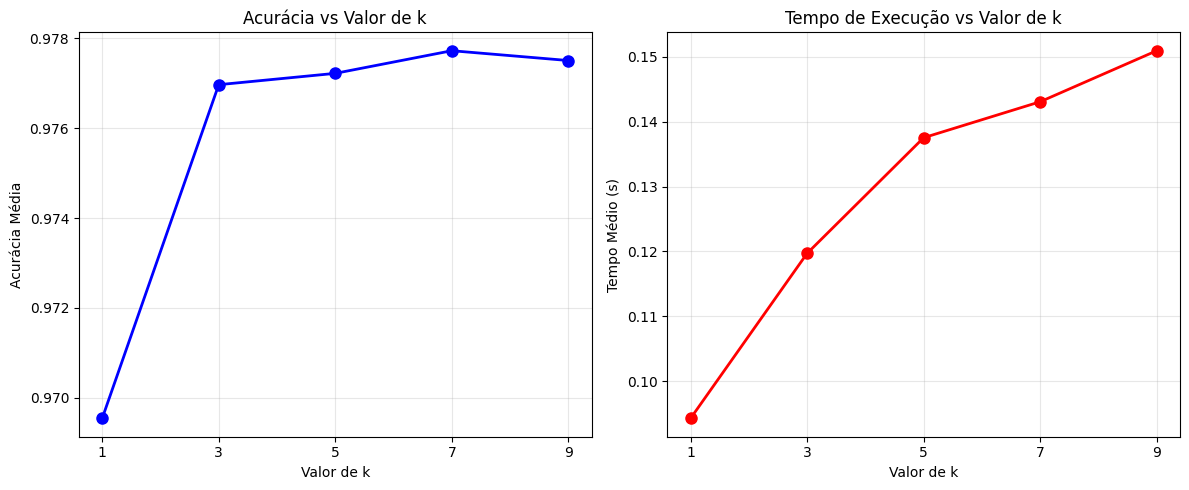

In [15]:
acuracias_medias = [todos_resultados[k]['acuracia_media'] for k in valores_k]
tempos_medios = [todos_resultados[k]['tempo_medio'] for k in valores_k]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(valores_k, acuracias_medias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Valor de k')
plt.ylabel('Acurácia Média')
plt.title('Acurácia vs Valor de k')
plt.grid(True, alpha=0.3)
plt.xticks(valores_k)

plt.subplot(1, 2, 2)
plt.plot(valores_k, tempos_medios, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Valor de k')
plt.ylabel('Tempo Médio (s)')
plt.title('Tempo de Execução vs Valor de k')
plt.grid(True, alpha=0.3)
plt.xticks(valores_k)

plt.tight_layout()
plt.show()

## Considerações Finais

In [16]:
print("RESUMO DA ANÁLISE")
print(f"Dataset: HTRU2 - {df.shape[0]} amostras, {df.shape[1]-1} features")
print(f"Algoritmo: k-Nearest Neighbors com distância Euclidiana")
print(f"Valores de k testados: {valores_k}")
print(f"Execuções por k: {num_execucoes}")
print(f"Divisão: {tamanho_treino} treino / {tamanho_teste} teste")
print(f"Normalização: StandardScaler")
print(f"Validação: Holdout com divisão treino/validação para seleção de k")

print(f"\nMELHOR DESEMPENHO")
melhor_resultado = todos_resultados[melhor_k_acuracia]
print(f"Melhor k: {melhor_k_acuracia}")
print(f"Acurácia: {melhor_resultado['acuracia_media']:.4f} ± {melhor_resultado['acuracia_std']:.4f}")
print(f"Precisão: {melhor_resultado['precisao_media']:.4f} ± {melhor_resultado['precisao_std']:.4f}")
print(f"Recall: {melhor_resultado['recall_media']:.4f} ± {melhor_resultado['recall_std']:.4f}")
print(f"Tempo: {melhor_resultado['tempo_medio']:.2f} ± {melhor_resultado['tempo_std']:.2f}s")
print(f"Protótipos utilizados: {melhor_resultado['prototipos']}")

print(f"\nCONCLUSÕES")
print(f"- Dataset desbalanceado requer análise cuidadosa das métricas")
print(f"- Todos os valores de k superaram o baseline de {baseline_majoritaria:.4f}")
print(f"- Normalização dos dados foi essencial para o kNN")
print(f"- Tempo de execução similar entre diferentes valores de k")
print(f"- Precisão e recall mais informativos que acurácia isolada")

RESUMO DA ANÁLISE
Dataset: HTRU2 - 17898 amostras, 8 features
Algoritmo: k-Nearest Neighbors com distância Euclidiana
Valores de k testados: [1, 3, 5, 7, 9]
Execuções por k: 5
Divisão: 6000 treino / 11898 teste
Normalização: StandardScaler
Validação: Holdout com divisão treino/validação para seleção de k

MELHOR DESEMPENHO
Melhor k: 7
Acurácia: 0.9777 ± 0.0006
Precisão: 0.9772 ± 0.0007
Recall: 0.9777 ± 0.0006
Tempo: 0.14 ± 0.02s
Protótipos utilizados: 3000

CONCLUSÕES
- Dataset desbalanceado requer análise cuidadosa das métricas
- Todos os valores de k superaram o baseline de 0.9084
- Normalização dos dados foi essencial para o kNN
- Tempo de execução similar entre diferentes valores de k
- Precisão e recall mais informativos que acurácia isolada
